<small>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, FaMAF UNC, 2021.</small>
# Aprendizaje Supervisado 

Este trabajo pertenece a la mentoría **GAP: Gestión Automática de Pedidos de Combustibles Líquidos basada en telemetría de inventarios**.

Integrantes:
- Bernaschini, María Laura
- Bosch, Daniela
- Sanabria, Ángel

## Introducción

En este trabajo se buscan realizar las predicciones finales, ahora teniendo en cuenta la estacionalidad de las series. Para esto se harán pruebas sobre los modelos de ARIMA, DecisionTreeRegressor y Prophet.

In [1]:
!pip install prophet
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
import plotly.graph_objects as go
import sklearn.metrics as metrics
from plotly.subplots import make_subplots
from datetime import datetime, date
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from prophet import Prophet

seaborn.set_context('talk')
# Set float format
pd.set_option('display.float_format','{:.5f}'.format)
pd.set_option('mode.chained_assignment', None)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel')
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640533 sha256=158695a7b63865e35c41eec0b538d22b1a666e7a0ccd2defdfa9ce6e0c3f4e83
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_pkl_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_pickle(filename)

def read_csv_from_drive(drive, id, filename, usecols, parse_dates, dtypes):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(
        filename, 
        dtype=dtypes, 
        parse_dates=parse_dates,
        usecols=usecols
    )

drive_connection = connect_to_drive()

In [3]:
#pkl_key2 = '1SztUxzHZjf1mmNRC77KmJ2p33urOxibT'
pkl_key2 = '11ihPPpzsS_9R5Kb--ZQNuDjFTzYkgc4C'
#df = read_pkl_from_drive(drive_connection, pkl_key2, 'df_curated_per_hour.pkl')
df = read_pkl_from_drive(drive_connection, pkl_key2, 'curated_df.pkl')

In [4]:
df = df.sort_index()
df.head()

id_equipo nombre_producto  ...  consumo_escl  equipo_producto
timestamp                             ...                               
2021-01-01       477        VP Nafta  ...       0.00000     477-VP Nafta
2021-01-01       900     Nafta Super  ...       0.00000  900-Nafta Super
2021-01-01       900        VP Nafta  ...       0.00000     900-VP Nafta
2021-01-01       520     DIESEL EURO  ...       0.00000  520-DIESEL EURO
2021-01-01       887      Diesel 500  ...       0.00000   887-Diesel 500

[5 rows x 9 columns]

## Feature engineering

Realizamos extracción, selección y creación de features que puedan ser relevantes para la predicción de los consumos.

Definimos algunas constantes de fechas que nos serán de utilidad para la generación de nuevos features en el dataset. Las mismas fueron extraídas de la página oficial del gobierno argentino (https://www.argentina.gob.ar/interior/feriados-nacionales-2021). Se intentaron utilizar algunos paquetes de Python con feriados y fechas importantes pero ninguno de ellos cuentan con datos de Argentina, por lo tanto decidimos generarlos manualmente.

In [5]:
HOLIDAYS = [
    date(2021, 1, 1), 
    date(2021, 2, 15), 
    date(2021, 2, 16), 
    date(2021, 3, 24), 
    date(2021, 4, 2), 
    date(2021, 5, 1), 
    date(2021, 5, 25)
]
NON_WORKING_DAYS = [
    date(2021, 3, 28), 
    date(2021, 3, 29), 
    date(2021, 4, 1), 
    date(2021, 4, 3), 
    date(2021, 4, 4), 
    date(2021, 5, 24)
]

Extraemos features como el día de la semana, la fecha (sin timestamp), turnos y generamos otros como los feriados y los días no laborables.

In [6]:
mask_working_hours =     (df.index.hour >= 9) & (df.index.hour < 19)
mask_sat_working_hours = (df.index.hour >= 9) & (df.index.hour < 13)

mask_morning_hours =     (df.index.hour >= 6) & (df.index.hour < 14)
mask_afternoon_hours =   (df.index.hour >= 14) & (df.index.hour < 22)
mask_night_hours =       (df.index.hour >= 22) | (df.index.hour < 6)

mask_weekend = df.index.weekday > 4
mask_saturday = df.index.weekday == 5

In [7]:
df['day'] = df.index.dayofweek
df['date'] = df.index.date

# Feriados y no laborables
df['is_holiday'] = df["date"].isin(HOLIDAYS)
df['is_non_working_day'] = df["date"].isin(NON_WORKING_DAYS)

# sábados por la mañana
df['is_working_hour_sat'] = (mask_working_hours & ~mask_weekend) | (mask_sat_working_hours & mask_saturday)

# Turnos
df['is_morning_shift'] = mask_morning_hours
df['is_afternoon_shift'] = mask_afternoon_hours
df['is_night_shift'] = mask_night_hours

In [8]:
df['month'] = df.index.month
df['year'] = df.index.year

## Entrenamiento de los datos

El entrenamiento y la predicción se hará sobre los consumos acumulados y no sobre el volumen, tal como se planteó en el trabajo anterior. Además, debemos convertir el datetime a valores ordinales ya que los algoritmos no trabajan con este tipo de datos.

In [9]:
# Consumos acumulados
df.loc[:,'consumo_accum'] = df.groupby('equipo_producto')['consumo_escl'].transform("cumsum")

# Transformación del datetime a numérico
datetime_range = pd.date_range(start='2021-01-01', end='2021-04-01', closed='left', freq='5T')
ordinal_datetime_dict = { k: i for (i, k) in enumerate(datetime_range) }
df["ordinal_datetime"] = df.index.map(ordinal_datetime_dict)

In [10]:
data_site_541 = df[df["equipo_producto"] == "541-Diesel 500"]
capacidad = data_site_541.iloc[0]["capacidad"]

### Prophet

Realizamos el entrenamiento con Prophet. Debemos crear las columnas `ds` e `y`, solicitadas por el estimador.

In [11]:
data_site_541["ds"] = data_site_541.index
data_site_541["y"] = data_site_541["consumo_accum"]
data_site_541.head()

id_equipo nombre_producto  ...                  ds       y
timestamp                                      ...                            
2021-01-01 00:00:00       541      Diesel 500  ... 2021-01-01 00:00:00 0.00000
2021-01-01 00:05:00       541      Diesel 500  ... 2021-01-01 00:05:00 0.00000
2021-01-01 00:10:00       541      Diesel 500  ... 2021-01-01 00:10:00 0.00000
2021-01-01 00:15:00       541      Diesel 500  ... 2021-01-01 00:15:00 0.00000
2021-01-01 00:20:00       541      Diesel 500  ... 2021-01-01 00:20:00 0.00000

[5 rows x 23 columns]

In [12]:
date_from = '2021-03-15 00:00:00'

In [13]:
## Dividimos el dataset en train y test
X_train = data_site_541[:date_from]["ds"]
y_train = data_site_541[:date_from]["y"]
X_test = data_site_541[date_from:]["ds"]
y_test = data_site_541[date_from:]["y"]

train = data_site_541[:date_from][["ds", "y"]]
test = data_site_541[date_from:][["ds", "y"]]

In [14]:
h = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(HOLIDAYS),
  'lower_window': 0,
  'upper_window': 1,
})
nw = pd.DataFrame({
  'holiday': 'non_working_day',
  'ds': pd.to_datetime(NON_WORKING_DAYS),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((h, nw))

In [15]:
m = Prophet(holidays=holidays)
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [16]:
# Tiempo en adelante a predecir y frecuencia
future = m.make_future_dataframe(periods=4895, freq='5T')

In [17]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds    yhat  yhat_lower  yhat_upper
25915 2021-03-31 23:35:00 5.92932     5.07647     6.86866
25916 2021-03-31 23:40:00 5.92972     5.06607     6.86761
25917 2021-03-31 23:45:00 5.93011     5.07110     6.87421
25918 2021-03-31 23:50:00 5.93048     5.07151     6.87364
25919 2021-03-31 23:55:00 5.93083     5.06812     6.86366

Observamos el consumo predecido por Prophet.

In [18]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=data_site_541["consumo_accum"]*capacidad,
        name="Consumo real"
    )
)
fig.add_trace(
    go.Scatter(
        x=forecast[forecast["ds"] >= date_from]["ds"], 
        y=(forecast[forecast["ds"] >= date_from]["yhat"])*capacidad,
        name="Predicción"
    )
)
fig.update_layout(title="Predicción del consumo con Prophet")
fig.show()

Calculamos el volumen a partir del consumo predecido.

In [19]:
predicted = forecast.set_index("ds")
volumen_inicial = data_site_541.loc[date_from]["volumen_escl"]
data_site_541["volumen_pred"] = volumen_inicial - (predicted["yhat"] - predicted.loc[date_from]["yhat"])

Ahora necesitamos obtener la fecha y la hora en que este sitio llega a cierto nivel de combustible. Buscamos la fecha más cercana para el nivel 3.000 sobre la predicción.

In [20]:
datetime_predicted = (data_site_541.loc[date_from:]['volumen_pred']*capacidad - 3000).apply(lambda x: max(x, 0)).idxmin()
datetime_predicted

Timestamp('2021-03-17 11:25:00')

Visualizamos.

In [21]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["is_holiday"], capacidad, 0), 
        name="Feriado", 
        fill='tozeroy',
        line=dict(color="rgba(191, 224, 205, 0.8)"),
        fillcolor="rgba(191, 224, 205, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["is_non_working_day"], capacidad, 0), 
        name="No laborable", 
        fill='tozeroy',
        line=dict(color="rgba(191, 224, 222, 0.8)"),
        fillcolor="rgba(191, 224, 222, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["day"] == 6, capacidad, 0), 
        name="Domingo", 
        fill='tozeroy',
        line=dict(color="rgba(222, 191, 224, 0.8)"),
        fillcolor="rgba(222, 191, 224, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=data_site_541["volumen_escl"]*capacidad,
        name="Volumen real"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541[date_from:].index, 
        y=data_site_541[date_from:]["volumen_pred"]*capacidad, 
        connectgaps=True,
        name="Predicción"
    )
)
fig.update_layout(shapes=[
    dict(
      type='line', xref='x',
      y0=0, y1=capacidad,
      x0=datetime_predicted, x1=datetime_predicted,
      line=dict(color="#c61313", dash="dash", width=1)
    )
])
fig.update_yaxes(range=(0, capacidad))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Vemos que la fecha y hora predecida resulta bastante acorde al momento en que realmente el sitio se ha quedado con 3.000 lts. de combustible. Veamos la diferencia obtenida.

In [22]:
data_site_541.loc[datetime_predicted]['volumen_pred']*capacidad - data_site_541.loc[datetime_predicted]['volumen_escl']*capacidad

592.8617341572804

In [23]:
explained_variance = metrics.explained_variance_score(test["y"], forecast[forecast["ds"] > date_from]["yhat"])
mse = metrics.mean_squared_error(test["y"], forecast[forecast["ds"] > date_from]["yhat"]) 
r2 = metrics.r2_score(test["y"], forecast[forecast["ds"] > date_from]["yhat"])

print(f"Varianza explicada: {explained_variance}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

Varianza explicada: 0.9896429454026543
MSE: 0.009028571928162614
R2: 0.9240719543580277


### DTR

In [24]:
col_to_copy = ["ds", "y", "consumo_escl", "day", "month",	"year", "is_holiday", "is_non_working_day", "is_working_hour_sat", "is_morning_shift", "is_afternoon_shift", "is_night_shift"]
df_ang = data_site_541[col_to_copy].copy()

In [25]:
#Encoding, para que en las condiciones del arbol no tengan mas peso por valor las numeraciones de fecha
df_ang = pd.get_dummies(df_ang, columns=['day'], drop_first=False, prefix='day')
df_ang = pd.get_dummies(df_ang, columns=['month'], drop_first=False, prefix='year')
df_ang = pd.get_dummies(df_ang, columns=['year'], drop_first=False, prefix='year')
df_ang.head(1)

ds       y  consumo_escl  ...  year_2  year_3  year_2021
timestamp                                    ...                           
2021-01-01 2021-01-01 0.00000       0.00000  ...       0       0          1

[1 rows x 20 columns]

In [26]:
col_features = ["is_holiday",	"is_non_working_day",	"is_working_hour_sat",	"is_morning_shift",	"is_afternoon_shift",	"is_night_shift",	"day_0",	"day_1",	"day_2",	"day_3",	"day_4",	"day_5",	"day_6",	"year_1",	"year_2",	"year_3",	"year_2021"]

In [27]:
train_end = date_from

In [28]:
X_train_ang = df_ang[:train_end][col_features]
#y_train_ang = df_ang[:train_end]["y"]
y_train_ang = df_ang[:train_end]["consumo_escl"]

X_test_ang = df_ang[train_end:][col_features]
#y_test_ang = df_ang[train_end:]["y"]
y_test_ang = df_ang[train_end:]["consumo_escl"]
print("X train ",X_train_ang.shape)
print("y train ",y_train_ang.shape)
print("X test ",X_test_ang.shape)
print("y test ",y_test_ang.shape)

X train  (21025, 17)
y train  (21025,)
X test  (4895, 17)
y test  (4895,)


In [29]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [30]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train_ang, y_train_ang)

DecisionTreeRegressor()

In [31]:
pred_train_tree= dtree.predict(X_test_ang)

In [32]:
offset_y = df_ang[' 2021-03-15'].y
print(offset_y[0])

4.7752156


In [33]:
pred_train_tree_acum = offset_y[0] + np.cumsum(pred_train_tree)
print(pred_train_tree_acum)

[4.77535326 4.7754909  4.77562854 ... 5.91503635 5.91525118 5.91546601]


In [34]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=df_ang.index, y=df_ang.y*capacidad))
fig.add_trace(go.Scatter(x=y_test_ang.index, y=pred_train_tree_acum*capacidad))
fig.show()

#### Busco mejor modelo con grid search

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [37]:
parameters = {
    'max_depth': range(1, 35),
    'min_samples_split': range(10, 60, 10),
    'min_samples_leaf': range(1,20,1),
    'min_samples_split': [2, 3, 4,5],
  }
dtree_g = DecisionTreeRegressor(random_state=0)
dtree_best = GridSearchCV(dtree_g,parameters,cv=5, n_jobs=1, scoring='neg_mean_squared_error') # scoring="f1"

In [38]:
dtree_best.fit(X_train_ang,y_train_ang)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=1,
             param_grid={'max_depth': range(1, 35),
                         'min_samples_leaf': range(1, 20),
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='neg_mean_squared_error')

In [39]:
print("\n The best parameters across ALL searched params:\n",dtree_best.best_params_)
mejores_parametros = dtree_best.best_params_


 The best parameters across ALL searched params:
 {'max_depth': 7, 'min_samples_leaf': 19, 'min_samples_split': 2}


In [40]:
pred_train_best_tree= dtree_best.predict(X_test_ang)
pred_train_best_tree.shape

(4895,)

In [41]:
pred_train_best_tree_acum = offset_y[0] + np.cumsum(pred_train_best_tree)
print(pred_train_best_tree_acum)

[4.77542876 4.7756419  4.77585504 ... 5.92980519 5.93001833 5.93023147]


In [42]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=df_ang.index, y=df_ang.y*capacidad))
fig.add_trace(go.Scatter(x=y_test_ang.index, y=pred_train_best_tree_acum*capacidad))
fig.show()

In [43]:
pred_train_tree= dtree.predict(X_test_ang)
#print(np.sqrt(mean_squared_error(y_train_ang,pred_train_tree)))
#print(r2_score(y_train_ang, pred_train_tree))
pred_train_tree.shape
df_pred_acum = pd.DataFrame(pred_train_tree)

#pred_acum = pred_train_tree.transform("cumsum")
pred_best_tree_acum = df_pred_acum.transform("cumsum")
volumen_inicial = data_site_541.loc[date_from]["volumen_escl"]
data_site_541.loc[date_from:]["volumen_pred"] = volumen_inicial - (pred_train_best_tree_acum - pred_train_best_tree_acum[0])

In [44]:
datetime_predicted = (data_site_541.loc[date_from:]['volumen_pred']*capacidad - 3000).apply(lambda x: max(x, 0)).idxmin()
datetime_predicted

Timestamp('2021-03-16 19:40:00')

In [45]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["is_holiday"], capacidad, 0), 
        name="Feriado", 
        fill='tozeroy',
        line=dict(color="rgba(191, 224, 205, 0.8)"),
        fillcolor="rgba(191, 224, 205, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["is_non_working_day"], capacidad, 0), 
        name="No laborable", 
        fill='tozeroy',
        line=dict(color="rgba(191, 224, 222, 0.8)"),
        fillcolor="rgba(191, 224, 222, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["day"] == 6, capacidad, 0), 
        name="Domingo", 
        fill='tozeroy',
        line=dict(color="rgba(222, 191, 224, 0.8)"),
        fillcolor="rgba(222, 191, 224, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=data_site_541["volumen_escl"]*capacidad,
        name="Volumen real"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541[date_from:].index, 
        y=data_site_541[date_from:]["volumen_pred"]*capacidad, 
        connectgaps=True,
        name="Predicción"
    )
)
fig.update_layout(shapes=[
    dict(
      type='line', xref='x',
      y0=0, y1=capacidad,
      x0=datetime_predicted, x1=datetime_predicted,
      line=dict(color="#c61313", dash="dash", width=1)
    )
])
fig.update_yaxes(range=(0, capacidad))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [46]:
## USAR   con la prediccion sola, no con el acum pred_best_tree_acum
import sklearn.metrics as metrics
explained_variance=metrics.explained_variance_score(y_test_ang, pred_train_tree)
mse=metrics.mean_squared_error(y_test_ang, pred_train_tree) 
r2=metrics.r2_score(y_test_ang, pred_train_tree)

print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  0.1719
MSE:  0.0
r2:  0.1672


In [47]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=y_test_ang.index, y=y_test_ang*capacidad))
fig.add_trace(go.Scatter(x=y_test_ang.index, y=pred_train_tree*capacidad))
fig.show()

### ARIMA

El ARIMA es un modelo autorregresivo de medias móviles que describe la autocorrelación de los datos. Este modelo asume que la serie temporal es estacionaria, es decir, que no presenta tendencia y estacionalidad en el tiempo.

Lo primero que debemos hacer es asegurarnos que nuestra variable a predecir es estacionaria. Esto lo podemos hacer de diferentes maneras: observando la descomposición de la serie temporal o a través del test de adfuller. En este último caso, si el valor p es significativo nos está indicando que efectivamente la serie temporal es estacionaria.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



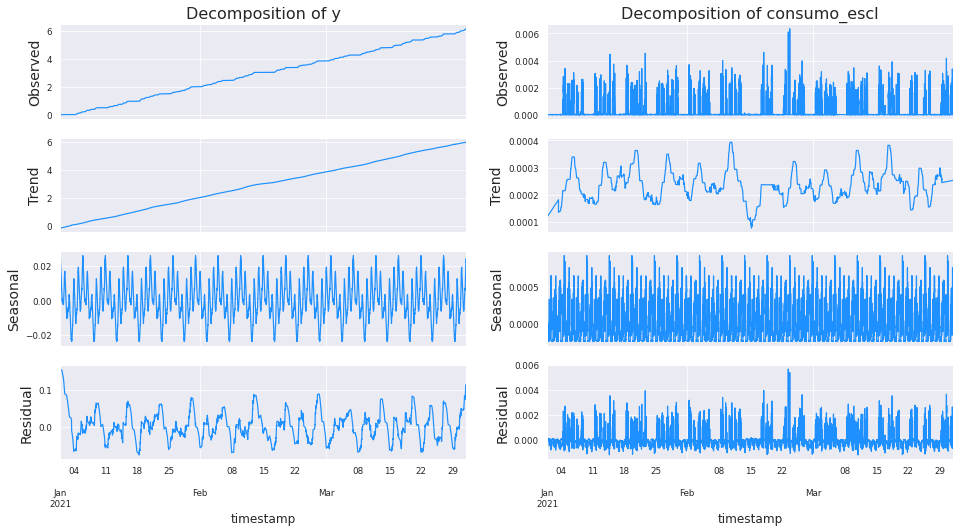

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(["y", "consumo_escl"]):
    
    res = seasonal_decompose(data_site_541[column], freq=60*24, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

In [49]:
from statsmodels.tsa.stattools import adfuller
result_du_c = adfuller(data_site_541['y'], autolag='AIC') ## p > a 0.05 serie estacional
result_du_c

(0.5843319811957055,
 0.9872230047071192,
 49,
 25869,
 {'1%': -3.43060281027498,
  '10%': -2.5668294730598618,
  '5%': -2.861651734652698},
 -362187.64450164017)

In [50]:
result_du_ce = adfuller(data_site_541['consumo_escl'], autolag='AIC') # p< 0.05 serie estacionaria
result_du_ce

(-15.155852446022775,
 6.696423721543893e-28,
 49,
 25869,
 {'1%': -3.43060281027498,
  '10%': -2.5668294730598618,
  '5%': -2.861651734652698},
 -362204.21178754047)

Como podemos observar, la variable a predecir "consumo acumulado" no es estacionaria (p > 0.05), esto es evidente ya que la naturaleza de la variable lo indica. Es por esto que debemos eliminar la tendencia de esta variable o trabajar con el consumo instantáneo que, como lo indica el test de adfuller, es estacionario (p < 0.05).

Se eliminará la tendecia de la variable "consumo acumulado" a través de la deferenciación (diferencia entre las observaciones) como se muestra a continuación.

In [51]:
consumo_accum_diff = np.diff(data_site_541['consumo_accum'])
data_site_541['consumo_accum_diff'] = np.append([0], consumo_accum_diff)


Chequeamos que la nueva variable ("consumo acumulado diferencial") sea estacionaria a través del test de adfuller. Los resultados indican que si se cumple con la asumpción de estacionariedad (p < 0.05).

In [52]:
from statsmodels.tsa.stattools import adfuller
result_du_c = adfuller(data_site_541['consumo_accum_diff'], autolag='AIC') ## p < a 0.05 serie estacionaria
result_du_c

(-15.155694494537121,
 6.699689375844521e-28,
 49,
 25869,
 {'1%': -3.43060281027498,
  '10%': -2.5668294730598618,
  '5%': -2.861651734652698},
 -362203.83867266745)

Se ajustará el ARIMA a esta nueva variable "consumo acumulado diferencial"  que sería lo mismo que trabajar con la variable consumo instantáneo. 

In [53]:
X_train = data_site_541[:date_from]["ds"]
y_train = data_site_541[:date_from]["consumo_accum_diff"]
X_test = data_site_541[date_from:]["ds"]
y_test = data_site_541[date_from:]["consumo_accum_diff"]

In [54]:
from statsmodels.tsa.arima_model import ARIMA
#y_train_sq=numpy.sqrt(y_train)
model = ARIMA(y_train, order=(0,0,0), freq="5T")
model_fit_arima = model.fit()
print(model_fit_arima.summary())

                              ARMA Model Results                              
Dep. Variable:     consumo_accum_diff   No. Observations:                21025
Model:                     ARMA(0, 0)   Log Likelihood              126759.358
Method:                           css   S.D. of innovations              0.001
Date:                Thu, 30 Dec 2021   AIC                        -253514.717
Time:                        14:20:53   BIC                        -253498.810
Sample:                    01-01-2021   HQIC                       -253509.525
                         - 03-15-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   4.02e-06     56.522      0.000       0.000       0.000


In [55]:
model = ARIMA(y_train, order=(1,1,0))
model_fit_arima2 = model.fit()
print(model_fit_arima2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency 5T will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency 5T will be used.



                              ARIMA Model Results                               
Dep. Variable:     D.consumo_accum_diff   No. Observations:                21024
Model:                   ARIMA(1, 1, 0)   Log Likelihood              141811.765
Method:                         css-mle   S.D. of innovations              0.000
Date:                  Thu, 30 Dec 2021   AIC                        -283617.530
Time:                          14:20:53   BIC                        -283593.669
Sample:                      01-01-2021   HQIC                       -283609.742
                           - 03-15-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -2.328e-11   2.31e-06  -1.01e-05      1.000   -4.52e-06    4.52e-06
ar.L1.D.consumo_accum_diff     0.1484      0.007     21.762      0.

In [56]:
model = ARIMA(y_train, order=(1,1,1), freq="5T")
model_fit_arima3 = model.fit()
print(model_fit_arima3.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                              ARIMA Model Results                               
Dep. Variable:     D.consumo_accum_diff   No. Observations:                21024
Model:                   ARIMA(1, 1, 1)   Log Likelihood              143287.330
Method:                         css-mle   S.D. of innovations              0.000
Date:                  Thu, 30 Dec 2021   AIC                        -286566.660
Time:                          14:21:21   BIC                        -286534.846
Sample:                      01-01-2021   HQIC                       -286556.276
                           - 03-15-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.902e-09   2.17e-06     -0.002      0.998   -4.25e-06    4.24e-06
ar.L1.D.consumo_accum_diff    -0.6792      0.005   -126.767      0.

In [57]:
y_pred, se, conf = model_fit_arima3.forecast(4895)

In [58]:
import sklearn.metrics as metrics
explained_variance=metrics.explained_variance_score(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred) 
r2=metrics.r2_score(y_test, y_pred)

print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  -0.0004
MSE:  0.0
r2:  -0.1983


El modelo ARIMA tuvo un ajuste muy pobre evidenciado por el valor negativo de las méstricas r2 y varianza explicada.

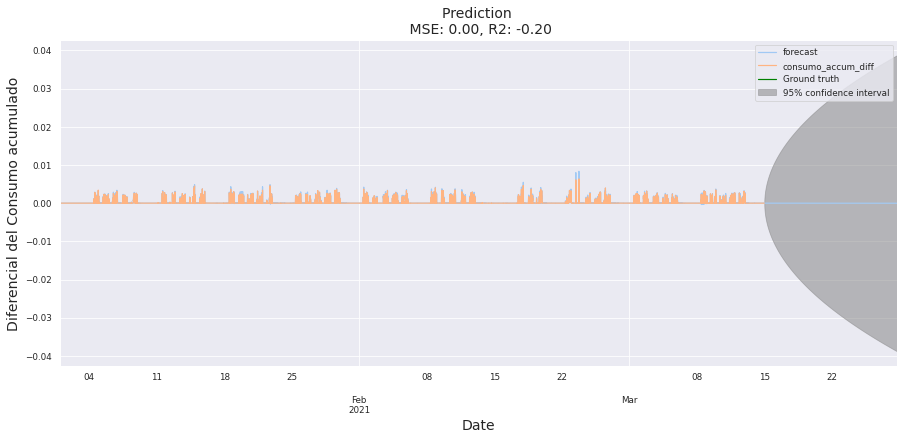

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit_arima3.plot_predict(1, 25000, ax=ax)
seaborn.lineplot(x=X_test.index, y=y_test, ax=ax, color='green', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MSE: {mse:.2f}, R2: {r2:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Diferencial del Consumo acumulado', fontsize=14)

plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [60]:
volumen_inicial = data_site_541.loc[date_from]["volumen_escl"]
data_site_541.loc[date_from:]["volumen_pred"] = volumen_inicial - (y_pred - y_pred[0])

In [61]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["is_holiday"], capacidad, 0), 
        name="Feriado", 
        fill='tozeroy',
        line=dict(color="rgba(191, 224, 205, 0.8)"),
        fillcolor="rgba(191, 224, 205, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["is_non_working_day"], capacidad, 0), 
        name="No laborable", 
        fill='tozeroy',
        line=dict(color="rgba(191, 224, 222, 0.8)"),
        fillcolor="rgba(191, 224, 222, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=numpy.where(data_site_541["day"] == 6, capacidad, 0), 
        name="Domingo", 
        fill='tozeroy',
        line=dict(color="rgba(222, 191, 224, 0.8)"),
        fillcolor="rgba(222, 191, 224, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541.index, 
        y=data_site_541["volumen_escl"]*capacidad,
        name="Volumen real"
    )
)
fig.add_trace(
    go.Scatter(
        x=data_site_541[date_from:].index, 
        y=data_site_541[date_from:]["volumen_pred"]*capacidad, 
        connectgaps=True,
        name="Predicción"
    )
)
fig.update_layout(shapes=[
    dict(
      type='line', xref='x',
      y0=0, y1=capacidad,
      x0=datetime_predicted, x1=datetime_predicted,
      line=dict(color="#c61313", dash="dash", width=1)
    )
])
fig.update_yaxes(range=(0, capacidad))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Conclusiones

- De los tres modelos probados, podemos decir que el PROPHET fue el que mejor ajuste tuvo según las métricas definidas, seguido por el DTR y, por último, por el ARIMA que tuvo un ajuste muy pobre con valores negativos de las métricas.
- En algunos casos puede ser conveniente predecir fecha y hora en lugar de volumen.
- Se deberían tener en cuenta los días y horarios en que las empresas reciben los pedidos de combustible para la predicción. 
- Se debe tener en cuenta además la logística de las empresas distribuidoras de combustible.